<a href="https://colab.research.google.com/github/Evaggelou/Arvato-Project-/blob/main/Arvato_Project_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

# magic word for producing visualizations in notebook
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('/content/drive/MyDrive/Udacity/Arvato/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('/content/drive/MyDrive/Udacity/Arvato//Udacity_CUSTOMERS_052018.csv', sep=';')

# Ignore any empty columns while loading data
no_unamed = lambda x: 'Unnamed' not in x

attributes = pd.read_excel('/content/drive/MyDrive/Udacity/Arvato/DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
attributes_info = pd.read_excel('/content/drive/MyDrive/Udacity/Arvato/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
azdias = pd.read_csv('/content/drive/MyDrive/Udacity/Arvato/Udacity_AZDIAS_052018.csv', sep=';')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
attributes_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


#### Find the excpected values for each feature
We can find from the "DIAS Attributes - Values 2017.xlsx" schema file what are the expected values foe each feature.

In [8]:
def find_attributes_names_values(attributes):
    """
    Description:
        Find the expected values for each feature according to the schema
    INPUT:
    attributes - (pandas dataframe) with detailed mapping of data values for each feature
    OUTPUT:
    attributes_names_values - a dataframe where at first column is name for each feature and
    at the second the expected value  
    """
    attr_name=[]
    attr_values=[]
    attr_values_temp=[]
    i=-1
    for j in range(len(attributes)):
        if attributes.iloc[j].Attribute == attributes.iloc[j].Attribute:
            attr_name.append(attributes.iloc[j].Attribute)
            if j!=0:
                attr_values.append(attr_values_temp)
            attr_values_temp=[] 
        attr_values_temp.append(attributes.iloc[j].Value)
    attr_values.append(attr_values_temp)

    attributes_names_values = pd.DataFrame({'attr_name':attr_name,'attr_values':attr_values})

    return attributes_names_values

In [9]:
attributes_names_values = find_attributes_names_values(attributes)
attributes_names_values.head()

,attr_name,attr_values
0,AGER_TYP,"[-1, 0, 1, 2, 3]"
1,ALTERSKATEGORIE_GROB,"[-1, 0, 1, 2, 3, 4, 9]"
2,ALTER_HH,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,ANREDE_KZ,"[-1, 0, 1, 2]"
4,ANZ_HAUSHALTE_AKTIV,[…]


#### Check values at the Udacity_AZDIAS_052018.csv file

In [10]:
print(f"azdias shape: {azdias.shape}")
azdias.head()

azdias shape: (891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,24,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2,12,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4,7,1,5,4,4,4,1,4,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6,43,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2,4,4,2,3,6,4,2,4,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,817722.000000,794005.000000,797481.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,770025.000000,794005.00000,886367.000000,886367.000000,886367.000000,839995.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,793947.000000,817722.000000,793435.000000,793435.000000,817722.000000,793947.00000,891221.000000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,0.040647,0.154018,1.727637,7.599356,0.004162,3.167854,4.153043,3.632838,3.335264,3.368086,3.195014,3.351290,3.336151,3.360684,3.465980,0.122336,0.219907,9.267420,0.892735,0.568580,0.106769,9.926794,9.439073,0.705221,0.425645,0.467869,1.145516,0.485508,0.257938,1.585405,...,4.257967,3.07222,3.419630,3.233723,3.863797,3.023813,4.667550,4.481405,4.272729,4.445007,4.763223,4.025014,4.359086,4.001597,4.256076,3.910139,4.240609,3.945860,3.661784,4.023709,1.266967,0.008423,2.539212,0.003483,3.223125,4.017526,0.090067,4.58576,1.197852,0.43882,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,0.324028,0.502389,1.155849,14.332201,0.068855,1.002376,2.183710,1.595021,1.493633,1.368331,1.401382,1.396508,1.373077,1.378992,1.328456,0.535950,0.747903,1.735725,2.011838,1.643764,0.808179,0.605641,1.547773,2.552707,1.510782,1.542151,2.266999,1.639340,1.252328,2.547925,...,2.030385,1.36298,1.417741,1.388687,1.282747,1.502725,1.795712,1.807552,1.915885,1.852412,1.830789,1.903816,2.022829,1.857540,1.770137,1.580306,2.007373,1.946564,1.707637,2.077746,1.287435,0.091392,0.754926,0.084957,1.255785,1.118399,0.286278,8.47152,0.952532,1.14329,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00

When we read the file we have a DtypeWarning about the columns 18 and 19. 
Let's explore them:

In [12]:
azdias.iloc[:,18:20].head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8,51
2,4,24
3,2,12
4,6,43


In [13]:
azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [14]:
azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

We have both int and float type and 'X' at CAMEO_DEUG_2015 and 'XX' at CAMEO_INTL_2015. So we have to convert all the values to float

Find which are the expected values for the 2 feature and replace the accordingly

In [15]:
attributes_names_values[attributes_names_values.attr_name=='CAMEO_DEUG_2015']

,attr_name,attr_values
10,CAMEO_DEUG_2015,"[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]"


In [16]:
attributes_names_values[attributes_names_values.attr_name=='CAMEO_INTL_2015']

,attr_name,attr_values


In the schema we only have information about the CAMEO_DEUG_2015 and we can see that there is non 'X' value and instead of nan we have -1. We can follow the same logic aldo for the CAMEO_INTL_2015.

In [45]:
# Let's fix it straightaway
def fix_CAMEO_columns(df):
    """
    Description:
        Convert int values to float at features CAMEO_DEUG_2015, CAMEO_INTL_2015
        Replace X and XX with -1
    INPUT:
    df - (pandas dataframe) df dataframe
    
    OUTPUT:
    df - dataframe with fixed features   
    """
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X': np.nan})
    # df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].fillna(value= -1)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    # df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].fillna(value= -1)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    return df

TypeError: ignored

In [18]:
# check columns
print(f"CAMEO_DEUG_2015 : {azdias.CAMEO_DEUG_2015.unique()}")
print(f"CAMEO_INTL_2015 : {azdias.CAMEO_INTL_2015.unique()}")

CAMEO_DEUG_2015 : [nan  8.  4.  2.  6.  1.  9.  5.  7.  3. -1.]
CAMEO_INTL_2015 : [nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32. -1.]


#### Check values at the Udacity_CUSTOMERS_052018.csv file

In [19]:
print(f"customers shape: {customers.shape}")
customers.head()

customers shape: (191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1,13,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,3.0,1,3,5,1,3,4,7,6,2,1,2,6,1,6,3,0.0,3.0,0.0,4.0,4.0,0.0,8.0,1,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,...,NaN,NaN,NaN,3,3,6,2,3,4,5,6,4,1,2,3,1,7,3,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1,0.0,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,1.0,5,7,2,6,7,1,7,3,4,2,1,2,1,3,1,0.0,3.0,0.0,1.0,5.0,0.0,0.0,2,0.0,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,4C,4,24,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,2.0,3,3,5,3,3,4,5,4,3,3,3,6,4,7,0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,1,0.0,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,7B,7,41,6.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1,2,3,5,0,3,10,7,0.0,0,0,6,...,4.0,3.0,5.0,5,4,5,2,3,5,6,6,5,5,4,4,4,5,1,0.0,3.0,0.0,2.0,4.0,0.0,1.0,2,0.0,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


We notice that the Excel spreadsheet has some feratures that are not in the population dataset and vice versa


In [20]:
# find the difference in spreadsheet and in the population
atributes_list = attributes.Attribute.unique().tolist()
azdias_list = azdias.columns.unique().tolist()
print("Common:")
print(f"Both in spreadsheet and in the population: {len(np.intersect1d(azdias_list,atributes_list))}")
print("\nDifferences:")
print(f"In population and not in the spreadsheet: {len(np.setdiff1d(azdias_list,atributes_list))}")
print(f"In spreadsheet and not in the population: {len(np.setdiff1d(atributes_list,azdias_list))}")

Common:
Both in spreadsheet and in the population: 272

Differences:
In population and not in the spreadsheet: 94
In spreadsheet and not in the population: 43


In [21]:
np.unique(azdias.dtypes)

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [61]:
azdias[azdias.dtypes[azdias.dtypes=='object'].index]

,D19_LETZTER_KAUF_BRANCHE
1,NaN
2,D19_UNBEKANNT
3,D19_UNBEKANNT
4,D19_SCHUHE
5,D19_ENERGIE
...,...
891216,D19_HAUS_DEKO
891217,D19_UNBEKANNT
891218,D19_BEKLEIDUNG_GEH
891219,D19_UNBEKANNT


In [88]:
attributes[attributes.Attribute=='PRAEGENDE_JUGENDJAHRE']

,Attribute,Description,Value,Meaning
2054,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,"-1, 0",unknown


In [95]:
attributes.Meaning.unique()

array(['unknown', 'no classification possible', 'passive elderly',
       'cultural elderly', 'experience-driven elderly', '< 30 years',
       '30 - 45 years', '46 - 60 years', '> 60 years',
       'uniformly distributed', 'unknown / no main age detectable',
       '01.01.1895 bis 31.12.1899', '01.01.1900 bis 31.12.1904',
       '01.01.1905 bis 31.12.1909', '01.01.1910 bis 31.12.1914',
       '01.01.1915 bis 31.12.1919', '01.01.1920 bis 31.12.1924',
       '01.01.1925 bis 31.12.1929', '01.01.1930 bis 31.12.1934',
       '01.01.1935 bis 31.12.1939', '01.01.1940 bis 31.12.1944',
       '01.01.1945 bis 31.12.1949', '01.01.1950 bis 31.12.1954',
       '01.01.1955 bis 31.12.1959', '01.01.1960 bis 31.12.1964',
       '01.01.1965 bis 31.12.1969', '01.01.1970 bis 31.12.1974',
       '01.01.1975 bis 31.12.1979', '01.01.1980 bis 31.12.1984',
       '01.01.1985 bis 31.12.1989', '01.01.1990 bis 31.12.1994',
       '01.01.1995 bis 31.12.1999', 'male', 'female',
       'numeric value (typically cod

In [82]:
azdias_temp = pd.get_dummies(azdias, columns=['D19_LETZTER_KAUF_BRANCHE'])

In [85]:
for attr in azdias_temp.columns:
    print(f"{attr}: {list(attributes[attributes.Attribute==attr].Description)}")

AGER_TYP: ['best-ager typology']
AKT_DAT_KL: []
ALTER_HH: ['main age within the household']
ALTERSKATEGORIE_FEIN: []
ANZ_HH_TITEL: ['number of academic title holder in building']
ANZ_KINDER: []
ANZ_PERSONEN: ['number of adult persons in the household']
ANZ_TITEL: ['number of professional title holder in household ']
ARBEIT: []
BALLRAUM: ['distance to next urban centre ']
CAMEO_DEUG_2015: ['CAMEO classification 2015 - Uppergroup']
CAMEO_INTL_2015: []
CJT_GESAMTTYP: ['customer journey typology']
CJT_KATALOGNUTZER: []
CJT_TYP_1: []
CJT_TYP_2: []
CJT_TYP_3: []
CJT_TYP_4: []
CJT_TYP_5: []
CJT_TYP_6: []
D19_BANKEN_ANZ_12: ['transaction activity BANKS in the last 12 months']
D19_BANKEN_ANZ_24: ['transaction activity BANKS in the last 24 months']
D19_BANKEN_DATUM: ['actuality of the last transaction for the segment banks TOTAL']
D19_BANKEN_DIREKT: []
D19_BANKEN_GROSS: []
D19_BANKEN_LOKAL: []
D19_BANKEN_OFFLINE_DATUM: ['actuality of the last transaction for the segment banks OFFLINE']
D19_BANKE

In [70]:
attributes.iloc[349:349+12]

,Attribute,Description,Value,Meaning
349,D19_GESAMT_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months
350,NaN,NaN,1,10% Online-transactions within the last 12 months
351,NaN,NaN,2,20% Online-transactions within the last 12 months
352,NaN,NaN,3,30% Online-transactions within the last 12 months
353,NaN,NaN,4,40% Online-transactions within the last 12 months
354,NaN,NaN,5,50% Online-transactions within the last 12 months
355,NaN,NaN,6,60% Online-transactions within the last 12 months
356,NaN,NaN,7,70% Online-transactions within the last 12 months
357,NaN,NaN,8,80% Online-transactions within the last 12 months
358,NaN,NaN,9,90% Online-transactions within the last 12 months


In [22]:
unique_azdias_per_col=[]
for col in azdias:
    print(f"Type: {azdias[col].dtypes}, Unique values at {col}:{azdias[col].unique()}")
    unique_azdias_per_col.append(azdias[col].unique())

Type: int64, Unique values at LNR:[910215 910220 910225 ... 825772 825776 825787]
Type: int64, Unique values at AGER_TYP:[-1  2  3  0  1]
Type: float64, Unique values at AKT_DAT_KL:[nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]
Type: float64, Unique values at ALTER_HH:[nan  0. 17. 13. 20. 10. 14. 16. 21. 11. 19. 15.  9. 18.  8.  7. 12.  4.
  3.  6.  5.  2.  1.]
Type: float64, Unique values at ALTER_KIND1:[nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]
Type: float64, Unique values at ALTER_KIND2:[nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]
Type: float64, Unique values at ALTER_KIND3:[nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]
Type: float64, Unique values at ALTER_KIND4:[nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]
Type: float64, Unique values at ALTERSKATEGORIE_FEIN:[nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.
 23.  4. 24.  6.  3.  2.  5. 25.  1.]
Type: float64, Unique values at A

In [23]:
def convert_int_to_float(df):
    '''
    Description
    Convert int values to float
    INPUT: dataframe
    OUTPUT: dataframe
    '''
    int_col = df.select_dtypes(include='int').columns
    df[int_col] = df[int_col].astype(float)
    return df

azdias = convert_int_to_float(azdias)

### Mising Values

#### Find how many are the missing values at every Column

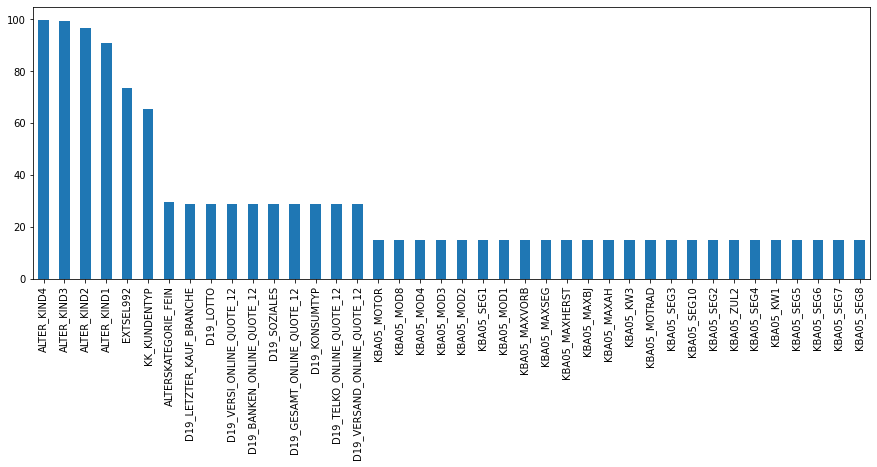

In [24]:
missing_values = (np.sum(azdias.isnull(),axis=0)*100/azdias.shape[0]).sort_values(ascending=False)

missing_values[:40].plot(figsize = (15,5), kind='bar')

Text(0, 0.5, '# of features')

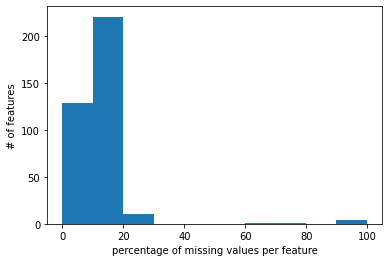

In [25]:
plt.hist(missing_values)
plt.xlabel("percentage of missing values per feature")
plt.ylabel("# of features")

With the above plots we can see that the most features have less than 20% missing values and we have some features with more than 80% so I will remove the features that have more than 35% missing values.

In [26]:
def drop_columns(df, threshold=0.35):
    """
    Description:
        Drop columns with more than 35% null values (calculated from the population dataset)
    INPUT:
        df (dataframe): population or customer dataframe
    OUTPUT:
        df (dataframe): dataset without dropped columns 
    """
    
    columns_to_drop = [s for s, v in (azdias.isnull().sum() > azdias.shape[0] * threshold).items() if v]

    df = df.drop(columns_to_drop, axis=1)
    print("Dropped {} columns.".format(len(columns_to_drop)))
    
    return df

azdias = drop_columns(azdias)

Dropped 6 columns.


Find features that have too many categories

In [27]:
azdias['LNR'].unique().shape[0]

891221

In [28]:
# Let's have a look at the other categorical features (the ones who are left)

categorical_to_drop = []
for categ in azdias.columns.values:
    num_categs = azdias[categ].value_counts().shape[0]
    if num_categs > 50:
        print("Feature {} has {} categories".format(categ, num_categs))
        categorical_to_drop.append(categ)
list(categorical_to_drop)

Feature LNR has 891221 categories
Feature ANZ_HAUSHALTE_AKTIV has 292 categories
Feature ANZ_STATISTISCHE_HAUSHALTE has 268 categories
Feature EINGEFUEGT_AM has 5162 categories
Feature GEBURTSJAHR has 117 categories
Feature KBA13_ANZAHL_PKW has 1261 categories


['LNR',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'EINGEFUEGT_AM',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW']

In [29]:
high_categorical = ['LNR',
                    'ANZ_HAUSHALTE_AKTIV',
                    'ANZ_STATISTISCHE_HAUSHALTE',
                    'EINGEFUEGT_AM',
                    'GEBURTSJAHR',
                    'KBA13_ANZAHL_PKW']

In [30]:
azdias["CAMEO_INTL_2015"].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32., -1.])

In [31]:
def drop_high_categorical(df, num_cat=40):
    """
    DESCRIPTION:
        Drop features with high cardinality
    INPUT:
        df (dataframe): dataframe
    
    OUTPUT:
        df (dataframe): dataframe without dropped features
    
    """
    drop_featrures = []
    for categ in df.columns:
        uniq_categs = df[categ].unique().shape[0]
        if uniq_categs > num_cat:
            print(f"Feature {categ} with {uniq_categs} Categories")
            drop_featrures.append(categ)

    df = df.drop(drop_featrures, axis=1)
    return df


azdias = drop_high_categorical(azdias)

Feature LNR with 891221 Categories
Feature ANZ_HAUSHALTE_AKTIV with 293 Categories
Feature ANZ_STATISTISCHE_HAUSHALTE with 269 Categories
Feature CAMEO_DEU_2015 with 46 Categories
Feature EINGEFUEGT_AM with 5163 Categories
Feature GEBURTSJAHR with 117 Categories
Feature KBA13_ANZAHL_PKW with 1262 Categories
Feature LP_LEBENSPHASE_FEIN with 42 Categories
Feature VERDICHTUNGSRAUM with 47 Categories


In [32]:
azdias["LP_FAMILIE_GROB"].unique()

array([ 2.,  3.,  1.,  0.,  5.,  4., nan])

#### Find missing values per Row

We should check what is the mean percentage of missing values per subject (row) and find out if we have to remove some of the rows due to missing of informations about them.

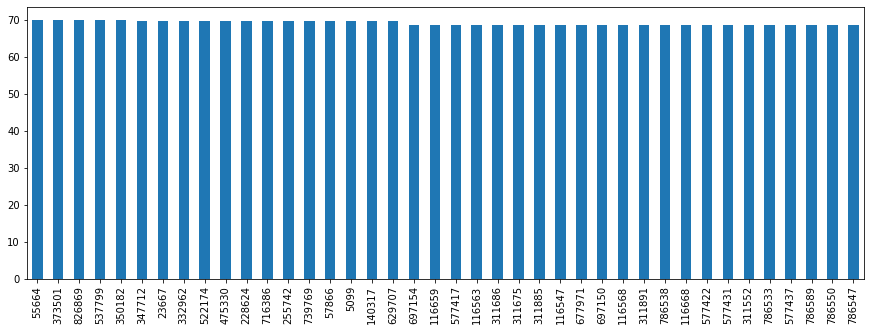

In [33]:
missing_rows = (np.sum(azdias.isnull(),axis=1)*100/azdias.shape[1]).sort_values(ascending=False)

missing_rows[:40].plot(figsize = (15,5), kind='bar')

Text(0, 0.5, '# of subjects')

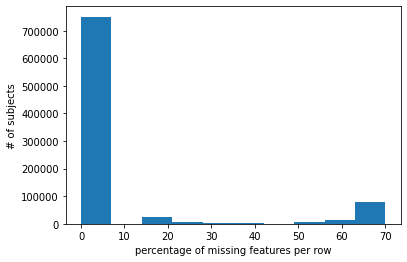

In [34]:
plt.hist(missing_rows)
plt.xlabel("percentage of missing features per row")
plt.ylabel("# of subjects")

We can clearly see that the most of the users have more than 50% of the feauters

In [35]:
def drop_rows_missing_values(df, threshold=0.5):
    """
        Drop rows with more than 50 null values
    INPUT:
        df : population or customer dataframe
    
    OUTPUT:
        df : cleared dataframe
    """
    df = df[df.isnull().sum(axis=1)<0.5*df.shape[1]]
    return df

azdias = drop_rows_missing_values(azdias)

#### Find the different information categories

The file "DIAS Information Levels - Attributes 2017.xlsx" is organized by informational category so we can find different categories and split the features by category.

In [36]:
attributes_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


We can see that the information level so the category and until the next one all the attributes are at this categoty. Also we notice that the Attribute AGER_TYP doesn't belong at any category so propably, from the description "in cooperation with Kantar TNS; the information basis is a consumer survey" I make the conclusion that it doesn't have any usefull information.

In [37]:
uniq_attributes = attributes_info.iloc[:,0].unique()
for uniq in uniq_attributes[1:]:
    print(np.where( attributes_info.iloc[:,0]==uniq)[0][0], uniq)

1 Person
43 Household
75 Building
85 Microcell (RR4_ID)
97 Microcell (RR3_ID)
152 125m x 125m Grid
185 Postcode 
189 RR1_ID
194 PLZ8
308 Community


#### Find categorical features

In [38]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,...,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,-1.0,9.0,0.0,21.0,0.0,0.0,2.0,0.0,3.0,6.0,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,3.0,4.0,1.0,5.0,3.0,5.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,2.0,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,-1.0,9.0,17.0,17.0,0.0,0.0,1.0,0.0,3.0,2.0,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,2.0,2.0,3.0,5.0,4.0,5.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,0.0,3.0,0.0,2.0,5.0,0.0,1.0,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,3.0,2.0,3.0,2.0,3.0,4.0,7.0,1.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,4.0,4.0,1.0,0.0,1.0,0.0,4.0,5.0,0.0,1.0,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,-1.0,1.0,20.0,14.0,0.0,0.0,4.0,0.0,4.0,2.0,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,5.0,1.0,2.0,0.0,10.0,5.0,10.0,6.0,6.0,1.0,6.0,0.0,6.0,0.0,1.0,5.0,0.0,0.0,...,8.0,5.0,5.0,5.0,3.0,5.0,5.0,2.0,4.0,4.0,2.0,3.0,6.0,4.0,2.0,4.0,2.0,4.0,6.0,2.0,7.0,2.0,0.0,3.0,0.0,4.0,3.0,0.0,2.0,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,3.0,1.0,10.0,10.0,0.0,0.0,1.0,0.0,2.0,6.0,8.0,54.0,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,3.0,5.0,3.0,3.0,4.0,4.0,3.0,4.0,2.0,4.0,4.0,4.0,5.0,2.0,4.0,7.0,7.0,7.0,2.0,6.0,2.0,0.0,0.0,2.0,0.0,3.0,3.0,0.0,2.0,0.0,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


In [39]:
# azdias["CAMEO_DEUG_2015"] = azdias["CAMEO_DEUG_2015"].map({'X': -1})
# azdias["CAMEO_DEUG_2015"].value_counts()

Series([], Name: CAMEO_DEUG_2015, dtype: int64)

In [40]:
# # -1 is unknown
# azdias["CAMEO_DEUG_2015"][azdias["CAMEO_DEUG_2015"]=='X']=-1
# azdias["CAMEO_DEUG_2015"][azdias["CAMEO_DEUG_2015"]!=azdias["CAMEO_DEUG_2015"]]=-1
# azdias["CAMEO_DEUG_2015"] = azdias["CAMEO_DEUG_2015"].astype(int)
# azdias["CAMEO_DEUG_2015"].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1])

In [41]:
temp_values = attributes_names_values[attributes_names_values.attr_name=='PLZ8_GBZ'].attr_values

In [42]:
# if np.isnan(np.setdiff1d(azdias["PLZ8_GBZ"].unique(),temp_values.values[0])[0]):
#     if np.setdiff1d(temp_values.values[0],azdias["PLZ8_GBZ"].unique())[0]==-1:
#         azdias["PLZ8_GBZ"] = azdias["PLZ8_GBZ"].fillna(value=-1)

In [43]:
# azdias["CAMEO_INTL_2015"].unique()
# azdias["CAMEO_INTL_2015"][azdias["CAMEO_INTL_2015"]=='XX']=-1
# azdias["CAMEO_INTL_2015"] = azdias["CAMEO_INTL_2015"].fillna(value=-1)
# azdias["CAMEO_INTL_2015"] = azdias["CAMEO_INTL_2015"].astype(float)
# azdias["CAMEO_INTL_2015"].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34., 55.,
       25., -1., 23., 31., 52., 35., 45., 44., 32.])

In [44]:
# azdias["CAMEO_DEU_2015"].unique()
# azdias["CAMEO_DEU_2015"][azdias["CAMEO_DEU_2015"]=='XX']= '00'
# azdias["CAMEO_DEU_2015"] = azdias["CAMEO_DEU_2015"].fillna(value= '00')
# azdias["CAMEO_DEU_2015"] = azdias["CAMEO_DEU_2015"].astype(str)
# azdias["CAMEO_DEU_2015"].unique()

KeyError: ignored

In [ ]:
# azdias["D19_LETZTER_KAUF_BRANCHE"].unique()
# azdias["D19_LETZTER_KAUF_BRANCHE"] = azdias["D19_LETZTER_KAUF_BRANCHE"].fillna(value= '00')
# azdias["D19_LETZTER_KAUF_BRANCHE"].unique()

In [ ]:
# azdias["OST_WEST_KZ"].unique()
# azdias["OST_WEST_KZ"] = azdias["OST_WEST_KZ"].fillna(value=-1)
# azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
# azdias["OST_WEST_KZ"].unique()

### clean data pipeline

In [46]:
def clean_data(df):
    print("Clean dataframe")

    # azdias = fix_CAMEO_columns(azdias)
    print("Remove columns with missing values more than 35%")
    df = drop_columns(df)

    print("Remove rows with missing values more than 50%")
    df = drop_rows_missing_values(df)
    
    print(f"Remove features with high Cardinality(more than 50 classes")
    df = drop_high_categorical(df)

    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})


In [47]:
clean_data(azdias)

Clean dataframe
Remove columns with missing values more than 35%
Dropped 0 columns.
Remove columns with missing values more than 35%
Dropped 0 columns.
Remove features with high Cardinality(more than 50 classes


In [60]:
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})


### Extra 

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')